<h1>Decision Tree- continuous variable</h1>

In [2]:
import numpy as np 
import pandas as pd 
import math
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

def fmt(x): return ('%.6f' % x).rjust(9)
def pnt(x): return ('{:.2f}%'.format(x*100)).rjust(4)

import sys
sys.path.append('../data')
from mylib import *
toPrint=False


<h3>Utility functions</h3>

In [4]:
def ConfusionTable(y_pred, y_test):
    XP=pd.DataFrame({'pred':y_pred, 'test':y_test, 'one':1})
    pt=XP.pivot_table(values='one', columns='pred', index='test',  aggfunc='count')
    pt=pt.replace(np.nan, 0)
    pt=pt.sort_index(axis=0,ascending=False).sort_index(axis=1,ascending=False)
    if pt.shape==(2,2):
        print("Accuracy: ", pnt((pt.iloc[0,0]+pt.iloc[1,1])/(pt.iloc[0,0]+pt.iloc[0,1]+pt.iloc[1,0]+pt.iloc[1,1])),
         "     Recall:   ", pnt(pt.iloc[0,0]/(pt.iloc[0,0]+pt.iloc[0,1])))
        print("Precision:", pnt(pt.iloc[0,0]/(pt.iloc[0,0]+pt.iloc[1,0])),
         "     F1 score: ", pnt(pt.iloc[0,0]*2/(pt.iloc[0,0]*2+pt.iloc[0,1]+pt.iloc[1,0])))
    display(pt)

def printTree(dic, nspace=0):
    nspace+=2
    if type(dic) is dict:
        for key in dic.keys():
            print('\n', ' '*nspace, key, ":", end='', sep='')
            printTree(dic[key], nspace)
        nspace-=2
    else:
        print(dic, end=' ', sep='')

x1=np.array([1,2,1,2,1,2,1,2])
x2=np.array([1,1,1,1,2,2,2,2])
ConfusionTable(x1, x2)

Accuracy:  50.00%      Recall:    50.00%
Precision: 50.00%      F1 score:  50.00%


pred,2,1
test,,
2,2,2
1,2,2


<h3>Basic functions for Decision Tree</h3>

In [3]:
def entropy(cls): ## after a series testing, this is by far the fastest
    tarray=np.unique(cls, return_counts=True)
    ent=0.0
    for count in tarray[1]:
        ratio=count/cls.shape[0]
        ent+=ratio*math.log(ratio,2)
    return -ent
 
def trySplit(df,attrib):
    ntotal=df.shape[0]
    ent=0.0
    for v, nodei in df.groupby(attrib):
        ent+=float(nodei.shape[0]/ntotal)*entropy(nodei[outcomeVar])
    return ent


<h2>Remaining issues</h2>
<br>
<font style='font-size:18px; line-height:28px;'>
<ul>
<li>How about using Gini impurity score for the measurements
<li>How about the continues variable
<li>Overfitting issue
<li>number of levels
</ul>
</font>

<h3>Gini Impurity Score</h3>
<br>
<font style='font-size:18px; line-height:28px;'>
<b>Gini impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.</b>

Let $S$ be a set of data of size $n$ and with distinct label $(c_1, c_2,..,c_k)$, each $c_i$ has probability $p_i=p(s=c_i)$, the Entropy of $S$ is defined as 

$$Entropy(S)=-\sum p_i Log_{2} (p_i)$$
We can describe its 'impurity' with Gini impurity score. It is defined by:

$$
Gini(S)=\sum_{i\ne j} p(s=c_i) p(s=c_j)~~~~~~ 1 \leq i,j \leq k
$$

Using shorthand notation $p_i=p(s=c_i)=n_i/n$, the above definition can be expressed as:

$$
Gini(S)=\sum_{i\ne j} p_i p_j=\sum_{i=1}^k\sum_{j=1,j \neq i}^k p_i p_j=\sum_{i=1}^k p_i\sum_{j=1, j\neq i}^k p_j=
   \sum_{i=1}^k p_i(1-p_i) = 1-\sum_{i=1}^kp_i^2
$$

$Gini(S)$ will be 0 when all the values in $S$ are the same, and it reaches its maximum value when all values are equally distributed.

</font>

In [6]:
def entropy(cls): ## after a series testing, this is by far the fastest
    tarray=np.unique(cls, return_counts=True)
    size=cls.shape[0]
    ent=0.0
    for count in tarray[1]:
        p=count/size
        ent+=p*math.log(p,2)
    return abs(ent)

def gini(cls): ## after a series testing, this is by far the fastest
    tarray=np.unique(cls, return_counts=True)
    size=cls.shape[0]
    score=0.0
    for count in tarray[1]:
        p=count/size
        score+=p*p
    return 1.0-score

def test(x):
    print('Entrypy', fmt(entropy(x)), '   Gini',fmt(gini(x)), '   Data', x, )

test(np.array([1,1,1,2,2,2]))  ## equal probability
test(np.array([9,9,9,1,1,1]))  ## values do not matter, the probability counts
test(np.array([1,1,1,1,2,2]))  ## value 1 become stronger
test(np.array([1,1,1,1,1,2]))  ## value 1 is dominating
test(np.array([1,1,1,1,1,1,3,4]))  ## nothing but value 1


Entrypy  1.000000    Gini  0.500000    Data [1 1 1 2 2 2]
Entrypy  1.000000    Gini  0.500000    Data [9 9 9 1 1 1]
Entrypy  0.918296    Gini  0.444444    Data [1 1 1 1 2 2]
Entrypy  0.650022    Gini  0.277778    Data [1 1 1 1 1 2]
Entrypy  1.061278    Gini  0.406250    Data [1 1 1 1 1 1 3 4]




<font style='font-size:18px; line-height:28px;'>
<h4>Categorical attrib vs continuous attributes</h4> 

So far we used only the categorical variable as attributes, we need to deal with the continuous variable too. The solution is to use a threshold value to split the attribute to two groups. For the classification (decision) trees, the "class" is alway a categorical variable, the entropy is <b>always</b> calculated on the class label, not on the actual attributes, both entropy and Gini score can be used for either categorical variable or continuous variables.

Note, not all numeric value are continuous, in fact, numeric coding of a categorical variable is very effictive way in the computing. We can not depend solely on variable typing to distinguesh them. Explicit definition may be the safest.

example:

- integer as categorical: most common 
- float as continuous: most common
- float as categorical: n/m is a float number, but only have a few distict values
- intger as continuous: age
- large integer as categorical: SIC4 (4 digit standard industry Code) range 1000 to 9999

</font>

### Cost-score of a split
<br>
<font style='font-size:18px; line-height:28px;'>
In decision tree applications, Gini impurity and Entropy can both used as cost function to evaluate splits in the dataset. A split in the dataset involves one input attribute and <b>one value</b> for that attribute. 

A Gini impurity gives an idea of how good a split is by how mixed the classes are in the two groups created by the split. A perfect separation results in a Gini score of 0, whereas the worst case split that results in 50/50 classes in each group result in a Gini score of 0.5 (for a 2 class problem).

We are examing how the cost score changes when the dataset $S$ is divided into $m$ subsets: $S=(S_1, S_2,...,S_m)$.

When entropy is used as the cost-score, the information gain is the criteria used to determind the split:

$$Gain(S,A)=Entropy(S)-\sum_{j=1}^m \frac{N(S_j)}{N(S)}Entropy(S_j)$$

Since the entropy of the dataset $S$ is a constant, to maximize the information gain Gain(S,A) is the same as minimize the weighted entropy 

$$ max~ Gain(S,A) <====> min~ \sum_{j=1}^m \frac{N(S_j)}{N(S)}Entropy(S_j)$$

When Gini impurity is used for the 'cost-score', the parallel definition is used:

$$
   Gini(s_1, s_2,...,s_m)=\sum_{i=1}^m \frac{N(s_i)}{N(S)}Gini(s_i)
$$

This is nice because both of them are very compatible in form. Both entropy and gini measurement describes same phenomenon:
<center> lower gini $\Leftrightarrow$ purer $\Leftrightarrow$ seperated more clearly $\Leftrightarrow$less entropy $\Leftrightarrow$ higher information gain</center>

In the next example, we use a boolean vector to hold both the 'greter than' portion and 'less than' portion. This boolean vector can be treated in the same way as what we used for the all-categorical-variable classification class DecisionTree, so we can reuse the code as much as possible.
</font>

In [6]:
### since we have built the recursive decision tree 
### classification class, we want to make as little 
### change as possible

def trySplit_discrete(df,attrib):
    ntotal=df.shape[0]
    score=0.0
    for v, subdf in df.groupby(attrib):
        print(subdf)
        print('------', measurement(subdf[outcomeVar]), '-----')
        score+=float(subdf.shape[0]/ntotal)*measurement(subdf[outcomeVar])
    print('Overall score for the split', score, '\n\n')
    return score

def trySplit_continuous(df,attrib, value):
    ntotal=df.shape[0]
    df['_'] = df[attrib] <= value
    score=0.0
    for v, subdf in df.groupby('_'):
        print(subdf)
        print('------', measurement(subdf[outcomeVar]), '-----\n')
        score+=float(subdf.shape[0]/ntotal)*measurement(subdf[outcomeVar])
    print('Overall score for the split', score, '\n\n')
    return score

df=pd.read_csv('../data/playTennis_N.csv')  #Outlook Temperature  Humidity  Windy Play
print(df,'\n\n')
outcomeVar='Play'
measurement=entropy    ### function assignment, the measurement is the same as entropy()
trySplit_discrete(df, 'Outlook')
trySplit_continuous(df, 'Humidity', 0.75)  ### we need to kown how to set this cut-off point

measurement=gini       ### now the measurement is gini()
trySplit_discrete(df, 'Outlook')
trySplit_continuous(df, 'Humidity', 0.75)

     Outlook Temperature  Humidity  Windy Play
0      sunny         hot      0.90  False   No
1      sunny         hot      0.87   True   No
2   overcast         hot      0.93  False  Yes
3       rain        mild      0.89  False  Yes
4       rain        cool      0.80  False  Yes
5       rain        cool      0.59   True   No
6   overcast        cool      0.77   True  Yes
7      sunny        mild      0.91  False   No
8      sunny        cool      0.68  False  Yes
9       rain        mild      0.84  False  Yes
10     sunny        mild      0.72   True  Yes
11  overcast        mild      0.49   True  Yes
12  overcast         hot      0.74  False  Yes
13      rain        mild      0.86   True   No 


     Outlook Temperature  Humidity  Windy Play
2   overcast         hot      0.93  False  Yes
6   overcast        cool      0.77   True  Yes
11  overcast        mild      0.49   True  Yes
12  overcast         hot      0.74  False  Yes
------ 0.0 -----
   Outlook Temperature  Humidity  Windy 

0.43174603174603166

### Consolidate the cases of descrete and continuous

<font style='font-size:18px; line-height:28px;'>
In above implementation, the value of spliting is needed for continuous variable. According to the rule of spliting, this value is to be selected to minimize the overall score. The next implementation achieve this goal: 
    
- explicitly specify the variable type to avoid ambiguity
- the cut-off value is searched internally
- return a tuple so it can be used as the key in dictionary
- for the categorical variable, the second part in the returning tuple is a None. 
</font>

In [9]:
### since we have built the recursive decision tree classification class, we want to make as little change as possible

def trySplit(df,attrib,iscontinuous=False):
    ntotal=df.shape[0]
    if iscontinuous:
        b_score=9999
        b_value=0
        for value in set(df[attrib]):
            df[workingVector]= df[attrib]<=value
            score=0.0
            for v, nodei in df.groupby(workingVector):
                score+=float(nodei.shape[0]/ntotal)*measurement(nodei[outcomeVar])
            if score < b_score:
                b_score, b_value= score, value
        return b_score, b_value
    else:
        score=0.0
        for v, nodei in df.groupby(attrib):
            score+=float(nodei.shape[0]/ntotal)*measurement(nodei[outcomeVar])
        return score, None 

df=pd.read_csv('../data/playTennis_N.csv')  #Outlook Temperature  Humidity  Windy Play
#print(df)
outcomeVar='Play'
measurement=entropy
workingVector='_'
workingVector='_'+str(random.randint(1,10000000))+'_' if workingVector is None else workingVector
print(trySplit(df, 'Outlook'))
print(trySplit(df, 'Humidity', True))

(0.6935361388961918, None)
(0.7041636107088363, 0.84)


In [41]:
df

,Outlook,Temperature,Humidity,Windy,Play,_
0,sunny,hot,0.90,False,No,False
1,sunny,hot,0.87,True,No,False
2,overcast,hot,0.93,False,Yes,False
3,rain,mild,0.89,False,Yes,False
4,rain,cool,0.80,False,Yes,False
5,rain,cool,0.59,True,No,True
6,overcast,cool,0.77,True,Yes,False
7,sunny,mild,0.91,False,No,False
8,sunny,cool,0.68,False,Yes,True
9,rain,mild,0.84,False,Yes,False


### Finding most significant split
<font style='font-size:18px; line-height:28px;'>
<ol>
<li>Try to divide the dataset to multiple subset so that each subset is <b>'pure'</b> by the attrib.
<li>compute the cost score for each subset, and summarize into one score for that attribute
<li>repeat the step 1 and 2 for all attributes in the dataset and select the 'best' attribute to make a divide.
<li>the attribute used in the division need to be dropped to avoid reuse
<li>when a attribute has only one value, the split need to be stopped
<li>repeat above step for all subsets and all attributes
</ol>
</font>

In [11]:
def getMostScoreAttrib(df):   ## the score include InformationGain and OverallGiniScore
    optScore, optValue, optVar =999, 0, ''
    for v in df.columns:
        if v!=outcomeVar and v!=workingVector: ## outcomeVar should be avoided, so does the temperary variable
            score, svalue =trySplit(df,v, v in continuousVars)
            if score<optScore:
                optScore, optValue, optVar=score, svalue, v
    return optVar, optValue    ## the argmin is what we need

df=pd.read_csv('../data/playTennis_N.csv') #Outlook Temperature  Humidity  Windy Play
#print(df)
outcomeVar='Play'
continuousVars=['Humidity']
workingVector='_'
measurement=entropy
getMostScoreAttrib(df)

('Outlook', None)

In [12]:
dd=pd.DataFrame({'X':[0.4,0.1,0.5,0.2,], 'Y':['-','+','-','+'],'_':[True,True,True, True]})
outcomeVar='Y'
workingVector='_'
continuousVars=['X']
getMostScoreAttrib(dd)

('X', 0.2)

In [13]:
def valueOfMaxProb(vals):
    tarray=np.unique(vals, return_counts=True)
    imax=np.argmax(tarray[1])
    return tarray[0][imax], tarray[1][imax]/vals.shape[0]

def value_count(vals):
    return np.unique(vals, return_counts=True)

def entropy(cls): ## after a series testing, this is by far the fastest
    tarray=np.unique(cls, return_counts=True)
    ent=0.0
    for count in tarray[1]:
        ratio=count/cls.shape[0]
        ent+=ratio*math.log(ratio,2)
    return -ent

def gini(cls): ## after a series testing, this is by far the fastest
    tarray=np.unique(cls, return_counts=True)
    size=cls.shape[0]
    score=0.0
    for count in tarray[1]:
        p=count/size
        score+=p*p
    return 1.0-score



Homework: wrap codes into a class. 

### Testing code

In [14]:
cdf=pd.read_csv('../data/CreditData.csv')
data=cdf.dropna()
data

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
2,a,24.5,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280,750,-


In [18]:
cdf=pd.read_csv('../data/CreditData.csv')
data=cdf.dropna()
selected_columns=['A'+str(i) for i in range(1,16)]
X=data[selected_columns]
y=data['A16']

np.random.seed(0)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape)
dt=DecisionTree()  
continuouesVars=['A2','A3','A8','A11','A14','A15']
%time dt.fit(X_train, y_train, continuouesVars)
print(dt.totalValueCount(dt.theTree)[1].sum())
assert dt.totalValueCount(dt.theTree)[1].sum()==X_train.shape[0], 'not all items are accounted for '
pred=dt.predict(X_test)
prob=dt.predict_proba(X_test)
ConfusionTable(y_test, pred)
roc(y_test==dt.labels[0], prob[:,0])
#print(dt.theTree)


(483, 15) (207, 15)


NameError: name 'DecisionTree' is not defined

In [16]:
df=pd.read_csv('../data/playTennis_N.csv')
#print(df)
dt1=DecisionTree(False,gini)
y=df.Play
X=df.copy()
del X['Play']
%time dt1.fit(X,y, ['Humidity'])
%time pred=dt1.predict(X)
%time prob=dt1.predict_proba(X)
printTree(dt1.theTree)
print(pred)
prob

NameError: name 'DecisionTree' is not defined

In [17]:
data

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
2,a,24.5,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280,750,-


(700, 6) (300, 6)
CPU times: user 356 ms, sys: 6.98 ms, total: 363 ms
Wall time: 358 ms
Accuracy:  70.67%      Recall:    69.93%
Precision: 71.81%      F1 score:  70.86%


pred,True,False
test,,
True,107,46
False,42,105


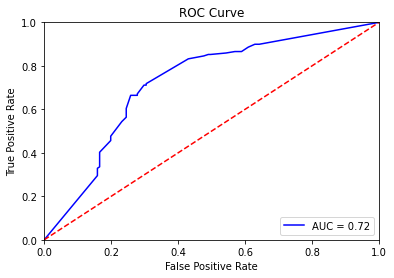


  ('der_hhsize', None):
    1:
      ('hld_rooms', None):
        1:
          ('hld_selfscale', None):
            1.0:
              ('hld_nbcellpho', None):
                0.0:
                  ('hid__101010160033', None):
                    0:
                      ('hid__101010160060', None):
                        0:(array([False,  True]), array([5, 1])) 
            2.0:(array([False]), array([5])) 
            3.0:(array([False]), array([1])) 
        2:
          ('hld_selfscale', None):
            1.0:
              ('hld_nbcellpho', None):
                0.0:
                  ('hid__101010160033', None):
                    0:
                      ('hid__101010160060', None):
                        0:(array([False,  True]), array([8, 4])) 
            2.0:
              ('hld_nbcellpho', None):
                0.0:
                  ('hid__101010160033', None):
                    0:
                      ('hid__101010160060', None):
                        0:(arra

            3:
              ('hld_selfscale', None):
                1.0:(array([ True]), array([6])) 
                2.0:
                  ('hid__101010160033', None):
                    0:
                      ('hid__101010160060', None):
                        0:(array([False,  True]), array([2, 6])) 
                3.0:(array([ True]), array([1])) 
            4:(array([ True]), array([9])) 
            5:
              ('hld_selfscale', None):
                1.0:(array([ True]), array([2])) 
                2.0:(array([ True]), array([1])) 
                3.0:(array([False]), array([1])) 
            6:
              ('hld_selfscale', None):
                1.0:
                  ('hid__101010160033', None):
                    0:
                      ('hid__101010160060', None):
                        0:(array([False,  True]), array([1, 1])) 
                2.0:(array([ True]), array([1])) 
                3.0:(array([ True]), array([1])) 
        1.0:
          ('hld

In [49]:
data=pd.read_pickle("../data/malawi_clear.zip")
data=data.iloc[:1000,:]
data=data.reset_index()
selected_columns=['der_hhsize', 'hld_rooms',
       'hld_nbcellpho', 'hld_selfscale', 'hid__101010160033',
       'hid__101010160060']
X=data[selected_columns]
y=data['poor']

np.random.seed(0)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape)
dt=DecisionTree(False,gini)
%time dt.fit(X_train, y_train)
pred=dt.predict(X_test)
prob=dt.predict_proba(X_test)
ConfusionTable(y_test, pred)
print()
#print(dt.theTree)
roc(y_test, prob[:,1])
printTree(dt.theTree)

(700, 8) (300, 8)
CPU times: user 2.44 s, sys: 22.1 ms, total: 2.46 s
Wall time: 2.45 s
Accuracy:  69.67%      Recall:    69.86%
Precision: 68.46%      F1 score:  69.15%


pred,True,False
test,,
True,102,44
False,47,107


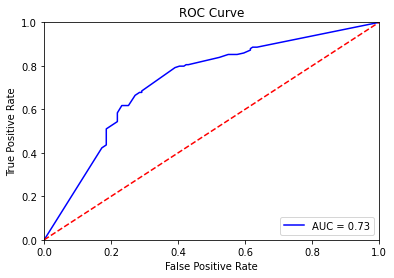


  ('der_hhsize', None):
    1:
      ('hld_rooms', None):
        1:
          ('wta_hh', 143.91940307617188):
            False:
              ('wta_pop', 143.91940307617188):
                False:
                  ('hld_nbcellpho', None):
                    0.0:
                      ('hld_selfscale', None):
                        1.0:
                          ('hid__101010160033', None):
                            0:
                              ('hid__101010160060', None):
                                0:(array([False,  True]), array([1, 1])) 
            True:(array([False]), array([10])) 
        2:
          ('wta_hh', 84.1155014038086):
            False:
              ('wta_pop', 84.1155014038086):
                False:
                  ('hld_selfscale', None):
                    1.0:
                      ('hld_nbcellpho', None):
                        0.0:
                          ('hid__101010160033', None):
                            0:
                    

                              ('hid__101010160060', None):
                                0:(array([False,  True]), array([1, 1])) 
                    True:(array([ True]), array([1])) 
                2.0:(array([False]), array([1])) 
        3:
          ('wta_hh', 78.24939727783203):
            False:
              ('hld_selfscale', None):
                1.0:
                  ('hld_nbcellpho', None):
                    0.0:(array([ True]), array([2])) 
                    1.0:(array([False]), array([1])) 
                    2.0:(array([ True]), array([1])) 
                2.0:
                  ('wta_pop', 522.823974609375):
                    False:
                      ('hld_nbcellpho', None):
                        0.0:
                          ('hid__101010160033', None):
                            0:
                              ('hid__101010160060', None):
                                0:(array([False,  True]), array([1, 2])) 
                        1.0:
     

                        3.0:(array([ True]), array([2])) 
                    5:(array([False]), array([1])) 
                True:
                  ('hld_rooms', None):
                    2:(array([False]), array([1])) 
                    3:(array([ True]), array([1])) 
                    4:(array([False]), array([1])) 
        2.0:
          ('wta_hh', 101.44989776611328):
            False:
              ('wta_pop', 507.2494812011719):
                False:
                  ('hld_rooms', None):
                    1:(array([False]), array([1])) 
                    3:(array([False]), array([4])) 
                    4:
                      ('hld_selfscale', None):
                        2.0:(array([ True]), array([1])) 
                        3.0:(array([False]), array([1])) 
                    6:(array([False]), array([1])) 
            True:(array([ True]), array([1])) 
    6:
      ('hld_nbcellpho', None):
        0.0:
          ('wta_hh', 207.39300537109375):
         

                    4:(array([False]), array([1])) 
                    6:(array([False]), array([1])) 
            True:
              ('hld_selfscale', None):
                1.0:(array([ True]), array([1])) 
                2.0:(array([ True]), array([4])) 
                3.0:
                  ('wta_pop', 901.6510620117188):
                    False:
                      ('hld_rooms', None):
                        3:(array([ True]), array([1])) 
                        4:(array([False]), array([1])) 
                        6:(array([ True]), array([1])) 
                    True:(array([ True]), array([2])) 
                4.0:
                  ('wta_pop', 361.9714050292969):
                    False:
                      ('hld_rooms', None):
                        4:
                          ('hid__101010160033', None):
                            0:
                              ('hid__101010160060', None):
                                0:(array([False,  True]), arra

In [50]:
# with continuous attributes
data=pd.read_pickle("../data/malawi_clear.zip")
data=data.iloc[:1000,:]
data=data.reset_index()
selected_columns=['wta_hh','wta_pop','der_hhsize', 'hld_rooms',
       'hld_nbcellpho', 'hld_selfscale', 'hid__101010160033',
       'hid__101010160060']
X=data[selected_columns]
y=data['poor']

np.random.seed(0)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape)
dt=DecisionTree(False,gini)
continuouesVars=['wta_hh','wta_pop']
%time dt.fit(X_train, y_train,continuouesVars)
pred=dt.predict(X_test)
prob=dt.predict_proba(X_test)
ConfusionTable(y_test, pred)
print()
#print(dt.theTree)
roc(y_test, prob[:,1])
printTree(dt.theTree)


  ('der_nchild10under', None):
    0:
      ('der_nfemalesover10', None):
        0:
          ('der_nmalesover10', None):
            1:
              ('hld_toilet__None', None):
                0:
                  ('der_nemployedpastyear', None):
                    0:
                      ('cons_0508__Yes', None):
                        0:
                          ('der_nliterate', None):
                            0:
                              ('hld_electricity__Yes', None):
                                0:
                                  ('cons_0504__Yes', None):
                                    0:(array([False,  True]), array([23,  1], dtype=int64)) 
                            1:
                              ('hld_electricity__Yes', None):
                                0:
                                  ('cons_0504__Yes', None):
                                    0:(array([False,  True]), array([22,  2], dtype=int64)) 
                                    1:

                            0:
                              ('hld_toilet__None', None):
                                0:
                                  ('cons_0504__Yes', None):
                                    0:(array([False,  True]), array([3, 4], dtype=int64)) 
                            1:(array([False]), array([1], dtype=int64)) 
                        1:(array([False]), array([2], dtype=int64)) 
                    3:
                      ('der_nemployedpastyear', None):
                        0:
                          ('hld_electricity__Yes', None):
                            0:
                              ('hld_toilet__None', None):
                                0:
                                  ('cons_0504__Yes', None):
                                    0:(array([False,  True]), array([4, 3], dtype=int64)) 
                        1:
                          ('hld_electricity__Yes', None):
                            0:
                             

                                1:(array([False]), array([1], dtype=int64)) 
                                2:(array([False]), array([1], dtype=int64)) 
                            3:(array([ True]), array([4], dtype=int64)) 
                            4:
                              ('der_nmalesover10', None):
                                1:
                                  ('hld_electricity__Yes', None):
                                    0:(array([False,  True]), array([2, 2], dtype=int64)) 
                                    1:(array([False]), array([1], dtype=int64)) 
                                2:(array([False]), array([1], dtype=int64)) 
                                3:(array([ True]), array([1], dtype=int64)) 
                            5:
                              ('der_nmalesover10', None):
                                2:
                                  ('hld_electricity__Yes', None):
                                    0:(array([False,  True]), array

                1:(array([False]), array([9], dtype=int64)) 
                2:
                  ('der_nfemalesover10', None):
                    1:(array([False]), array([1], dtype=int64)) 
                    2:(array([False]), array([2], dtype=int64)) 
                    3:
                      ('der_nemployedpastyear', None):
                        1:
                          ('hld_electricity__Yes', None):
                            0:
                              ('hld_toilet__None', None):
                                0:
                                  ('cons_0504__Yes', None):
                                    0:(array([False,  True]), array([1, 1], dtype=int64)) 
                3:(array([ True]), array([1], dtype=int64)) 
            4:
              ('hld_electricity__Yes', None):
                0:
                  ('der_nmalesover10', None):
                    1:(array([ True]), array([1], dtype=int64)) 
                    2:
                      ('der_n

                        4:(array([False]), array([1], dtype=int64)) 
                        5:
                          ('der_nmalesover10', None):
                            2:(array([ True]), array([1], dtype=int64)) 
                            3:(array([False]), array([1], dtype=int64)) 
                            4:(array([ True]), array([1], dtype=int64)) 
                        6:(array([ True]), array([1], dtype=int64)) 
                    2:
                      ('der_nmalesover10', None):
                        1:(array([False]), array([2], dtype=int64)) 
                        2:(array([ True]), array([1], dtype=int64)) 
                        3:(array([False]), array([1], dtype=int64)) 
                        4:(array([ True]), array([1], dtype=int64)) 
                3:
                  ('der_nemployedpastyear', None):
                    0:
                      ('der_nmalesover10', None):
                        0:
                          ('der_nliterate',

                      ('der_nmalesover10', None):
                        1:
                          ('hld_electricity__Yes', None):
                            0:
                              ('hld_toilet__None', None):
                                0:
                                  ('cons_0508__Yes', None):
                                    0:(array([False,  True]), array([1, 1], dtype=int64)) 
                    1:(array([False]), array([2], dtype=int64)) 
            4:(array([False]), array([14], dtype=int64)) 
            5:(array([False]), array([7], dtype=int64)) 
            6:(array([False]), array([10], dtype=int64)) 
            7:(array([False]), array([2], dtype=int64)) 
            9:(array([False]), array([1], dtype=int64)) 
            10:(array([False]), array([1], dtype=int64)) 
    3:
      ('cons_0508__Yes', None):
        0:
          ('cons_0504__Yes', None):
            0:
              ('der_nliterate', None):
                0:
                  ('d

                                    0:(array([False,  True]), array([1, 1], dtype=int64)) 
                            1:(array([ True]), array([1], dtype=int64)) 
                        3:
                          ('der_nfemalesover10', None):
                            1:
                              ('der_nemployedpastyear', None):
                                0:
                                  ('hld_electricity__Yes', None):
                                    0:(array([False,  True]), array([1, 1], dtype=int64)) 
                            2:
                              ('der_nemployedpastyear', None):
                                0:
                                  ('hld_electricity__Yes', None):
                                    0:(array([False,  True]), array([1, 1], dtype=int64)) 
                        4:
                          ('der_nfemalesover10', None):
                            2:
                              ('der_nemployedpastyear', None):
    

                        1:(array([False]), array([1], dtype=int64)) 
                3:
                  ('der_nliterate', None):
                    1:(array([ True]), array([1], dtype=int64)) 
                    6:(array([False]), array([1], dtype=int64)) 
                4:(array([ True]), array([2], dtype=int64)) 
            4:
              ('der_nliterate', None):
                4:(array([False]), array([1], dtype=int64)) 
                5:(array([ True]), array([1], dtype=int64)) 
                6:(array([ True]), array([3], dtype=int64)) 
                8:(array([False]), array([1], dtype=int64)) 
            5:(array([ True]), array([1], dtype=int64)) 
    4:
      ('cons_0504__Yes', None):
        0:
          ('hld_electricity__Yes', None):
            0:
              ('der_nliterate', None):
                0:
                  ('cons_0508__Yes', None):
                    0:
                      ('der_nmalesover10', None):
                        0:(array([ True])

                3:(array([ True]), array([1], dtype=int64)) 
                4:(array([ True]), array([1], dtype=int64)) 
            1:(array([False]), array([1], dtype=int64)) 
        2:
          ('cons_0508__Yes', None):
            0:(array([ True]), array([10], dtype=int64)) 
            1:(array([False]), array([2], dtype=int64)) 
        3:
          ('der_nliterate', None):
            0:(array([False]), array([1], dtype=int64)) 
            1:(array([ True]), array([1], dtype=int64)) 
            2:(array([False]), array([1], dtype=int64)) 
            3:(array([ True]), array([1], dtype=int64)) 
            4:(array([ True]), array([2], dtype=int64)) 
            5:(array([ True]), array([2], dtype=int64)) 
            7:(array([ True]), array([1], dtype=int64)) 
        4:(array([ True]), array([6], dtype=int64)) 
        5:(array([False]), array([1], dtype=int64)) 
        6:(array([False]), array([1], dtype=int64)) 
    6:
      ('der_nliterate', None):
        1:
      